# PDF Processing: Load, Chunk, and Prepare for Vector DB

This notebook demonstrates a step-by-step approach to loading, enriching,
chunking, and storing scientific paper PDFs into a vector database.
It compares different outputs at each stage interactively with helpful visualizations.

In [1]:
import json
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from IPython.display import display
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.vectorstores import Qdrant
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
)
from sklearn.decomposition import PCA
from tqdm import tqdm
from transformers import AutoTokenizer


In [2]:
MAX_DOCS = 10

In [3]:
# ## Step 1: Load Multiple PDF Documents

pdf_path = Path("../data/arxiv/pdfs/")  # change to your path
pdf_files = list(pdf_path.glob("*.pdf"))
metadata_path = Path("../data/arxiv/metadata/")  # change to your path

all_docs = []

print(f"Found {len(pdf_files)} PDF files in {pdf_path}")

Found 181 PDF files in ../data/arxiv/pdfs


In [4]:
for pdf_file in tqdm(pdf_files[:MAX_DOCS], desc="Loading PDFs"):
    try:
        loader = UnstructuredPDFLoader(file_path=pdf_file, mode="single")
        doc = loader.load()[0]

        metadata_file = pdf_file.with_suffix(".json")
        if metadata_file.exists():
            with open(metadata_file) as f:
                metadata = json.load(f)
            doc.metadata |= metadata

        all_docs.append(doc)
    except Exception as e:
        print(f"Failed to process {pdf_file}: {e}")

print(f"--- Loaded {len(all_docs)} documents ---")

Loading PDFs:   0%|          | 0/10 [00:00<?, ?it/s]CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, de

--- Loaded 10 documents ---


In [5]:
# ## Step 2: Recursive Chunking by Tokens

model_id = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=300,
    chunk_overlap=30,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

final_chunks = []
chunk_by_doc = {}
for doc in all_docs:
    doc_chunks = []
    for i, chunk in enumerate(splitter.split_text(doc.page_content)):
        metadata = doc.metadata.copy()
        metadata["chunk_index"] = i
        doc_chunks.append(Document(page_content=chunk, metadata=metadata))
    chunk_by_doc[doc.metadata.get("title", doc.metadata.get("source", "Document"))] = (
        doc_chunks
    )
    final_chunks.extend(doc_chunks)

chunk_lengths = [
    len(tokenizer.encode(chunk.page_content, truncation=False))
    for chunk in final_chunks
]

print(f"\n--- Final Chunk Stats ---")
print(f"Total chunks: {len(final_chunks)}")
print(
    f"Avg size: {np.mean(chunk_lengths):.2f}, Max: {np.max(chunk_lengths)}, Min: {np.min(chunk_lengths)}"
)
print(final_chunks[:10])

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors



--- Final Chunk Stats ---
Total chunks: 623
Avg size: 236.57, Max: 302, Min: 3
[Document(metadata={'source': '../data/arxiv/pdfs/2410.05160v3.pdf', 'chunk_index': 0}, page_content='5 2 0 2\n\nn a J\n\n2\n\n]\n\nV C . s c [\n\n3 v 0 6 1 5 0 . 0 1 4 2 : v i X r a\n\nManuscript\n\nVLM2VEC: TRAINING VISION-LANGUAGE MODELS FOR MASSIVE MULTIMODAL EMBEDDING TASKS\n\nZiyan Jiang1∗, Rui Meng2, Xinyi Yang2, Semih Yavuz2, Yingbo Zhou2, Wenhu Chen1 1University of Waterloo, 2Salesforce Research ziyanjiang528@gmail.com, ruimeng@salesforce.com, wenhuchen@uwaterloo.ca\n\nhttps://tiger-ai-lab.github.io/VLM2Vec/\n\nABSTRACT'), Document(metadata={'source': '../data/arxiv/pdfs/2410.05160v3.pdf', 'chunk_index': 1}, page_content='Embedding models have been crucial in enabling various downstream tasks such as semantic similarity, information retrieval, and clustering. Recently, there has been a surge of interest in developing universal text embedding models that can generalize across tasks (e.g., MTEB). How

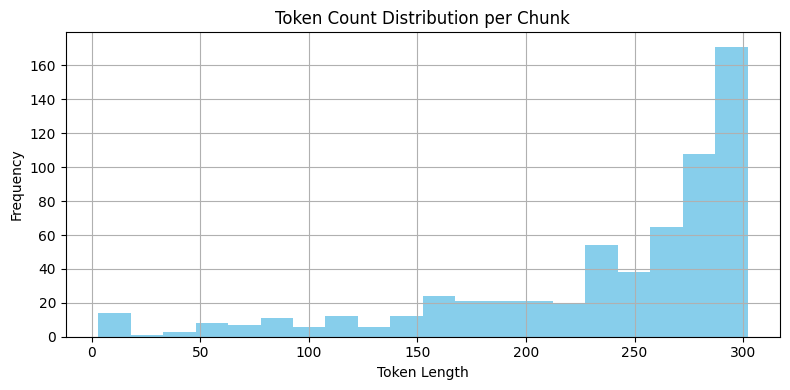

In [6]:
# Histogram of Chunk Sizes
plt.figure(figsize=(8, 4))
plt.hist(chunk_lengths, bins=20, color="skyblue")
plt.title("Token Count Distribution per Chunk")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
doc_selector = widgets.Dropdown(
    options=list(chunk_by_doc.keys()),
    description="Document:",
    layout=widgets.Layout(width="50%"),
)

chunk_slider = widgets.IntSlider(min=0, max=1, step=1, description="Chunk:")

output_area = widgets.Output()


def update_slider(*args):
    selected_doc = doc_selector.value
    chunk_slider.max = len(chunk_by_doc[selected_doc]) - 1
    chunk_slider.value = 0
    show_chunk(0)


def show_chunk(i):
    with output_area:
        output_area.clear_output()
        selected_doc = doc_selector.value
        chunk = chunk_by_doc[selected_doc][i]
        print(chunk.metadata)
        print("\n" + chunk.page_content[:1000])


chunk_slider.observe(lambda change: show_chunk(change["new"]), names="value")
doc_selector.observe(update_slider, names="value")

display(widgets.VBox([doc_selector, chunk_slider, output_area]))
update_slider()

In [8]:
# ## Step 3: Store in Qdrant Vector DB

embedding = HuggingFaceEmbeddings(model_name=model_id)

db = Qdrant.from_documents(
    documents=final_chunks,
    embedding=embedding,
    location="localhost:6333",
    collection_name="papers_demo",
    prefer_grpc=False,
)

print("\n--- Stored in Qdrant Vector DB ---")
print(f"Collection: {db.collection_name}")


--- Stored in Qdrant Vector DB ---
Collection: papers_demo


In [9]:
final_chunks[0].metadata

{'source': '../data/arxiv/pdfs/2410.05160v3.pdf', 'chunk_index': 0}

In [10]:
# Run PCA
texts = [doc.page_content for doc in final_chunks]
embeddings = embedding.embed_documents(texts)
pca = PCA(n_components=2)
points = pca.fit_transform(embeddings)

# Create color group
doc_names = [
    doc.metadata.get("title", doc.metadata.get("source", "Doc " + str(i)))
    for i, doc in enumerate(final_chunks)
]
unique_doc_ids = {name: i for i, name in enumerate(set(doc_names))}
colors = [unique_doc_ids[name] for name in doc_names]

# DataFrame for plot
df = pd.DataFrame({
    "x": points[:, 0],
    "y": points[:, 1],
    "document": doc_names,
    "chunk": [doc.metadata.get("chunk_index", 0) for doc in final_chunks],
    "preview": [doc.page_content[:100].replace("\n", " ") for doc in final_chunks],
    "color_id": colors
})


In [11]:

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="color_id",
    hover_data=["document", "chunk", "preview"],
    title="Interactive PCA Projection of Chunks"
)
fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(showlegend=False)
fig.show()
